In [484]:
import re
import numpy as np
import pandas as pd

# In[2]:
GPXfile='Lunch_Walk.gpx'
data = open(GPXfile).read()

# In[3]:


lat = np.array(re.findall(r'lat="([^"]+)',data),dtype=float)
lon = np.array(re.findall(r'lon="([^"]+)',data),dtype=float)
time = re.findall(r'<time>([^\<]+)',data)
dt = pd.to_datetime(time)
s = dt.astype(int)

coords = np.array(list(zip(lat,lon,time,dt,s)))
coords = coords[::1]

# In[4]:
print ('coords')

import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter
from datetime import datetime
#

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")


coords


In [485]:

Xi = coords[:, -2].reshape(-1, 1)#dt

Y0 = coords[:, 0].reshape(-1, 1).astype(np.float64)
Y1 = coords[:, 1].reshape(-1, 1).astype(np.float64)

Yi=np.array(list(zip(Y0,Y1))).astype(np.float64)


Xi = Xi



xx = [Xi[0],Xi[-1]]
Xi = Xi-xx[0]
Xi /= xx[1]-xx[0]



second = 1000000000

resolution = 0.0008
timegap = 60*second

Xarr = []
Yarr = []
Yold = [-999,-999]
Xold = -999
for j in range(len(Xi)):
    i = Yi[j][0][0]
    k = Yi[j][1][0]
    if abs(i-Yold[0])>resolution:
        Yarr.append([i,k])
        Yold=[i,k]
        Xold = Xi[j]
        Xarr.append(Xi[j])
    elif abs(Xi[j]-Xold)>timegap:
        Yarr.append([i,k])
        Yold=[i,k]
        Xold = Xi[j]
        Xarr.append(Xi[j])
    elif abs(k-Yold[1])>resolution:
        Yarr.append([i,k])
        Yold=[i,k]
        Xold = Xi[j]
        Xarr.append(Xi[j])
 


Xarr= np.array(Xarr).reshape(-1, 1).astype(np.float64)
Yarr= np.array(Yarr)#.reshape(-1, 1).astype(np.float64)




means=[]
scales = []
for q in [0,1]:

    scale = 1/Yarr[:,q].std()
    Yarr[:,q]=Yarr[:,q]*scale #1/resolution
    scales.append(scale)
    
    Ym = Yarr[:,q].mean()
    Yarr[:,q] = Yarr[:,q]-Ym
    means.append(Ym)
    


X=Xarr
Y=Yarr

In [486]:
'''
FIX 
'''
start = (X[0]*(xx[1]-xx[0]))+xx[0]
end =  (X[-1]*(xx[1]-xx[0]))+xx[0]

start,end


def gx(x):
    return [(i*(xx[1]-xx[0]))+xx[0] for i in x]

In [487]:
'''
FIY 
'''
scales = np.array(scales)
means  = np.array(means)


def gy(y):
    return np.array([(i+means)/scales for i in y])


scales , means,'v1',Y[10:12], 'v2',Yi[10:12],f,'','vout', gy(Y[10:12])

(array([361.18570063,  56.11632732]),
 array([ 1.86027161e+04, -8.79689237e+00]),
 'v1',
 array([[-0.40280584,  0.46788261],
        [-0.50429902,  0.42231615]]),
 'v2',
 array([[[51.50473 ],
         [-0.14197 ]],
 
        [[51.504742],
         [-0.141976]]]),
 51.504613000000006,
 '',
 'vout',
 array([[51.50346 , -0.148424],
        [51.503179, -0.149236]]))

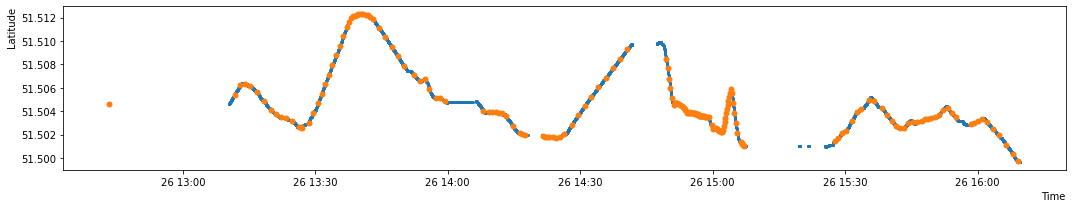

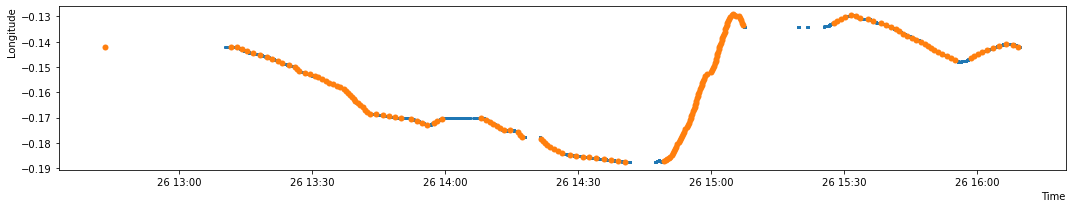

In [488]:
import matplotlib.pyplot as plt

Ynew = gy(Y)


for z in [0,1]: 
    plt.figure(figsize=(15,3))

    _ = plt.plot(gx(Xi), Yi[:,z], ".", mew=.0005)

    plt.plot(gx(X), Ynew[:,z], "o", mew=.005)


    plt.xlabel('Time', horizontalalignment='right', x=1.0)
    plt.ylabel(['Latitude','Longitude'][z], horizontalalignment='right', y=1.0)
    plt.tight_layout()

In [558]:
##########
#data


###########
# MAXITER = ci_niter(2000)
# D = 1  # number of input dimensions
# P = len(Y[0])  # number of observations = output dimensions
# M = len(Y)  # number of inducing points

# Zinit = np.linspace(0, 1, M)[:, None]




kernel =  gpflow.kernels.Matern52( variance=.1, lengthscales=.2)+gpflow.kernels.Matern52( variance=.1, lengthscales=.2)+ gpflow.kernels.White()# +gpflow.kernels.Exponential() 

m = gpflow.models.GPR(data=(Xarr, Yarr), kernel=kernel, mean_function=None)
m.trainable_variables

m.likelihood.variance.assign(0.01)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

data = (X,Y)

# def optimize_model_with_scipy(model):
#     optimizer = gpflow.optimizers.Scipy()
#     optimizer.minimize(
#         m.training_loss,
#         variables=model.trainable_variables,
#         options={"disp": True, "maxiter": MAXITER},
#     )


# optimize_model_with_scipy(m)

# print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0170206
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.00579452
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.1944
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.0577427
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,5.19528e-05
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,2.11337e-06


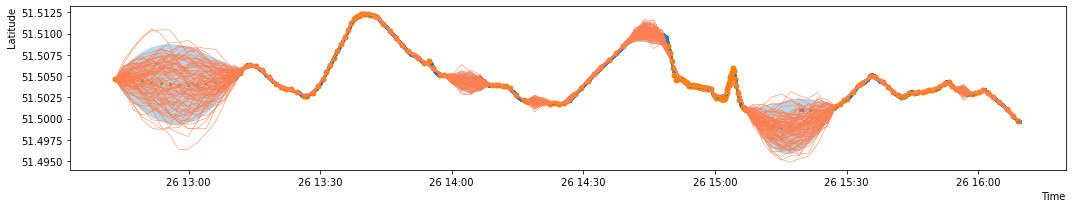

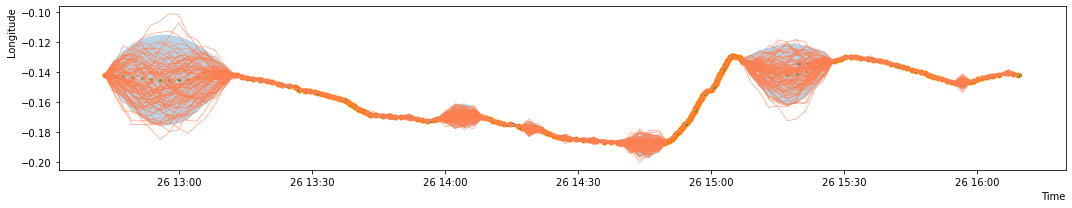

In [559]:
import matplotlib.pyplot as plt



pred = np.linspace(X[0], X[-1], 100)[:, None][:,0,:]
pX=gx(pred)


samples = m.predict_f_samples(pred, 100)  # shape (10, 100, 1)
val,err = m.predict_y(pred)
# if val.ndim == 3:
#      val= val[:, 0, :]



Yerr = err/scales**2
Ynew2 = gy(val)
sz = [gy(i) for i in  samples]

for z in [0,1]: 
    plt.figure(figsize=(15,3))

    _ = plt.plot(gx(Xi), Yi[:,z], ".", mew=.0005)

    plt.plot(gx(X), Ynew[:,z], "o", mew=.005)
    plt.plot(pX, Ynew2[:,z], ".", mew=.005)
    
    
    top = Ynew2[:,z] +  1.96* Yerr[:,z]**.5 #1.96 *
    bot = Ynew2[:, z] - 1.96 * Yerr[:, z] ** 0.5
    
#     plt.plot(pX, top, "-", mew=.005)
    plt.fill_between(np.array(pX)[:,0], np.array(top), np.array(bot), alpha=0.3)
    
    for s in sz:#[100,10,2]
        plt.plot(pX,s[:,z] ,'coral', linewidth=0.5)
#     


    plt.xlabel('Time', horizontalalignment='right', x=1.0)
    plt.ylabel(['Latitude','Longitude'][z], horizontalalignment='right', y=1.0)
    plt.tight_layout()
    

In [560]:
[str(i[0]) for i in xx]

['2020-12-26 12:43:14+00:00', '2020-12-26 16:09:37+00:00']

In [565]:

import tensorflow as tf
m.predict_f_compiled = tf.function(
    m.predict_f, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)]
)

m.xx =  tf.Variable([str(i[0]) for i in xx], name='xlim')
m.scaled =  tf.Variable(scales, name='scale')
m.means =  tf.Variable(means, name='means')



# @tf.function(input_signature=[tf.TensorSpec(shape=None, dtype=tf.float64)])
# def geolocate(x):
    
#     xx = pd.to_datetime(m.xx.numpy().astype(str))
    
#     err, val = m.predict_f_compiled( (x-xx[0])/(xx[1]-xx[0]) )
    
#     val = [(i+m.means)/m.scales for i in val]
#     # 
#     err *= m.scales**2
                   
                   
#     return val,err,xx,means,scales


# m.geolocate=geolocate

# @tf.function
# def params():
#     return scales,means

# m.params = params


# m.add_to_collection('CONSTANTS', tf.constant(value=66, name=test))

print ('')
save_dir = './gpe_locations'
tf.saved_model.save(m, save_dir)
print('')
print('saved')



INFO:tensorflow:Assets written to: ./gpe_locations/assets


INFO:tensorflow:Assets written to: ./gpe_locations/assets



saved


In [550]:
pd.to_datetime(m.xx.numpy().astype(str))

DatetimeIndex(['2020-12-26 12:43:14+00:00', '2020-12-26 16:09:37+00:00'], dtype='datetime64[ns, UTC]', freq=None)

In [ ]:

d=pd.to_datetime(['2020-12-26 12:43:14+00:00','2020-12-26 16:43:14+00:00'])


# @tf.function(input_signature=[tf.TensorSpec(shape=None, dtype=tf.float64)])
def decode(m,x):
    
    xx = pd.to_datetime(m.xx.numpy().astype(str))
    
    dates = np.array((x-xx[0])/(xx[1]-xx[0])).reshape(-1,1)
    print (dates)

    
    err, val = m.predict_f_compiled( dates )
    
    val = [(i+m.means)/m.scaled for i in val]
    # 
    err *= m.scaled**2
                   
                   
    return val,err,xx,m.means,m.scaled
 
    
 
decode(l,d)